In [32]:
import os, torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
from torch import optim
from torchsummary import summary

In [33]:
# 確定使用 CPU or Cuda
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [34]:
# 實作一個可以讀取 stanford dog (mini) 的 Pytorch dataset
class DogDataset(Dataset):
    
    def __init__(self, filenames, labels, transform):
        self.filenames = filenames    # 資料集的所有檔名
        self.labels = labels          # 影像的標籤
        self.transform = transform    # 影像的轉換方式
 
    def __len__(self):
        return len(self.filenames)    # return DataSet 長度
 
    def __getitem__(self, idx):       # idx: Inedx of filenames
        image = Image.open(self.filenames[idx]).convert('RGB')
        image = self.transform(image) # Transform image
        label = np.array(self.labels[idx])
        return image, label           # return 模型訓練所需的資訊

In [35]:
train_transformer = transforms.Compose([
    transforms.Resize(256), # 將圖像大小調整到256x256像素
    transforms.CenterCrop(224), # 從圖像中心裁剪出224x224像素的區域
    transforms.ToTensor(), # 圖像轉換成PyTorch的Tensor
    # 標準化處理 mean 代表平均值 std 代表標準差 利用每個通道的像素減去相應的均值除以標準差 可使像素值分佈接近標準正態分佈
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_transformer = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [36]:
# 參數設定
batch_size = 32                                  # Batch Size
lr = 1e-3                                        # Learning Rate
epochs = 10                                      # epoch 次數

train_data_dir = 'train'                         # 訓練集資料夾名稱
valid_data_dir = 'valid'                         # 驗證集資料夾名稱

In [38]:
def set_Train_Data(train_data_dir):
    dataset = ImageFolder(train_data_dir)
    print(dataset)
    # 建立所有類別的
    character = [[] for i in range(len(dataset.classes))]
    print(character)

    # 將每一類的檔名依序存入相對應的 list
    for x, y in dataset.samples:
        character[y].append(x)
        print(character[y])
      
    train_inputs, train_labels = [], []
    
    for i, data in enumerate(character): # 讀取每個類別中所有的檔名 (i: label, data: filename)
        np.random.seed(42)
        np.random.shuffle(data)
            
        # 存訓練集
        num_sample_train = int(len(data))
        print(str(i) + ': ' + str(len(data)) + ' | ' + str(num_sample_train))
        
        for x in data[:num_sample_train]:
            train_inputs.append(x)
            train_labels.append(i)
            

    train_dataloader = DataLoader(DogDataset(train_inputs, train_labels, train_transformer),
                                  batch_size = batch_size, shuffle = True)
    return train_dataloader



train_dataloader = set_Train_Data(train_data_dir)

Dataset ImageFolder
    Number of datapoints: 1702
    Root location: train
[[], [], [], [], [], [], [], [], [], [], [], [], [], [], []]
['train/Afghan/001.jpg']
['train/Afghan/001.jpg', 'train/Afghan/002.jpg']
['train/Afghan/001.jpg', 'train/Afghan/002.jpg', 'train/Afghan/003.jpg']
['train/Afghan/001.jpg', 'train/Afghan/002.jpg', 'train/Afghan/003.jpg', 'train/Afghan/004.jpg']
['train/Afghan/001.jpg', 'train/Afghan/002.jpg', 'train/Afghan/003.jpg', 'train/Afghan/004.jpg', 'train/Afghan/005.jpg']
['train/Afghan/001.jpg', 'train/Afghan/002.jpg', 'train/Afghan/003.jpg', 'train/Afghan/004.jpg', 'train/Afghan/005.jpg', 'train/Afghan/006.jpg']
['train/Afghan/001.jpg', 'train/Afghan/002.jpg', 'train/Afghan/003.jpg', 'train/Afghan/004.jpg', 'train/Afghan/005.jpg', 'train/Afghan/006.jpg', 'train/Afghan/007.jpg']
['train/Afghan/001.jpg', 'train/Afghan/002.jpg', 'train/Afghan/003.jpg', 'train/Afghan/004.jpg', 'train/Afghan/005.jpg', 'train/Afghan/006.jpg', 'train/Afghan/007.jpg', 'train/Afghan/0

In [39]:
def set_Val_Data(valid_data_dir):
    dataset = ImageFolder(valid_data_dir)
    print(dataset)
    # 建立所有類別的
    character = [[] for i in range(len(dataset.classes))]
    print(character)

    # 將每一類的檔名依序存入相對應的 list
    for x, y in dataset.samples:
        character[y].append(x)
        print(character[y])
      
    val_inputs, val_labels = [], []
    
    for i, data in enumerate(character): # 讀取每個類別中所有的檔名 (i: label, data: filename)
        np.random.seed(42)
        np.random.shuffle(data)

        # 存驗證集
        num_sample_val = int(len(data))
        print(str(i) + ': ' + str(len(data)) + ' | ' + str(num_sample_val))
        
        for x in data[:num_sample_val] :
            val_inputs.append(x)
            val_labels.append(i)
        

    val_dataloader = DataLoader(DogDataset(val_inputs, val_labels, train_transformer),
                                  batch_size = batch_size, shuffle = False)
    return val_dataloader

val_dataloader = set_Val_Data(valid_data_dir)

Dataset ImageFolder
    Number of datapoints: 140
    Root location: valid
[[], [], [], [], [], [], [], [], [], [], [], [], [], []]
['valid/Afghan/01.jpg']
['valid/Afghan/01.jpg', 'valid/Afghan/02.jpg']
['valid/Afghan/01.jpg', 'valid/Afghan/02.jpg', 'valid/Afghan/03.jpg']
['valid/Afghan/01.jpg', 'valid/Afghan/02.jpg', 'valid/Afghan/03.jpg', 'valid/Afghan/04.jpg']
['valid/Afghan/01.jpg', 'valid/Afghan/02.jpg', 'valid/Afghan/03.jpg', 'valid/Afghan/04.jpg', 'valid/Afghan/05.jpg']
['valid/Afghan/01.jpg', 'valid/Afghan/02.jpg', 'valid/Afghan/03.jpg', 'valid/Afghan/04.jpg', 'valid/Afghan/05.jpg', 'valid/Afghan/06.jpg']
['valid/Afghan/01.jpg', 'valid/Afghan/02.jpg', 'valid/Afghan/03.jpg', 'valid/Afghan/04.jpg', 'valid/Afghan/05.jpg', 'valid/Afghan/06.jpg', 'valid/Afghan/07.jpg']
['valid/Afghan/01.jpg', 'valid/Afghan/02.jpg', 'valid/Afghan/03.jpg', 'valid/Afghan/04.jpg', 'valid/Afghan/05.jpg', 'valid/Afghan/06.jpg', 'valid/Afghan/07.jpg', 'valid/Afghan/08.jpg']
['valid/Afghan/01.jpg', 'valid/A

In [40]:
C = models.vgg16(pretrained=True).to(device)     # 使用內建的 model 
optimizer_C = optim.SGD(C.parameters(), lr = lr) # 選擇你想用的 optimizer
summary(C, (3, 244, 244))                        # 利用 torchsummary 的 summary package 印出模型資訊，input size: (3 * 224 * 224)
# Loss function
criterion = nn.CrossEntropyLoss()                # 選擇想用的 loss function

/home/user01/AWINLABHW01/myenv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/user01/AWINLABHW01/myenv/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 244, 244]           1,792
              ReLU-2         [-1, 64, 244, 244]               0
            Conv2d-3         [-1, 64, 244, 244]          36,928
              ReLU-4         [-1, 64, 244, 244]               0
         MaxPool2d-5         [-1, 64, 122, 122]               0
            Conv2d-6        [-1, 128, 122, 122]          73,856
              ReLU-7        [-1, 128, 122, 122]               0
            Conv2d-8        [-1, 128, 122, 122]         147,584
              ReLU-9        [-1, 128, 122, 122]               0
        MaxPool2d-10          [-1, 128, 61, 61]               0
           Conv2d-11          [-1, 256, 61, 61]         295,168
             ReLU-12          [-1, 256, 61, 61]               0
           Conv2d-13          [-1, 256, 61, 61]         590,080
             ReLU-14          [-1, 256,

In [41]:
loss_epoch_C = []
train_acc, val_acc, test_acc = [], [], []
best_acc, best_auc = 0.0, 0.0

In [42]:
import time

if __name__ == '__main__':    
    for epoch in range(epochs):
        start_time = time.time()
        correct_train, total_train = 0, 0
        correct_val, total_val = 0, 0
        train_loss_C = 0.0

        C.train()  # 設定成訓練模式
        print(f'Epoch: {epoch + 1} / {epochs}')
        
        # 訓練階段
        for i, (x, label) in enumerate(train_dataloader):
            x, label = x.to(device), label.to(device)
            optimizer_C.zero_grad()                     
            train_output = C(x)                         
            train_loss = criterion(train_output, label)
            # 更新梯度權重
            train_loss.backward()             
            optimizer_C.step()                       
            
            _, predicted = torch.max(train_output.data, 1)
            total_train += label.size(0)
            correct_train += (predicted == label).sum().item()
            train_loss_C += train_loss.item()
            
        train_accuracy = 100 * correct_train / total_train
        print(f'Training - Epoch: {epoch + 1}, Loss: {train_loss_C / len(train_dataloader):.3f}, Accuracy: {train_accuracy:.3f}%')
        
        # 驗證階段
        C.eval()  # 設定為評估模式
        with torch.no_grad(): # 設定不要影響梯度
            for i, (x, label) in enumerate(val_dataloader):
                x, label = x.to(device), label.to(device)
                val_output = C(x)
                _, predicted = torch.max(val_output.data, 1)
                total_val += label.size(0)
                correct_val += (predicted == label).sum().item()
        
        val_accuracy = 100 * correct_val / total_val
        print(f'Validation - Accuracy: {val_accuracy:.3f}%')
                                     
        train_acc.append(train_accuracy)
        val_acc.append(val_accuracy)
        loss_epoch_C.append(train_loss_C / len(train_dataloader))

        end_time = time.time()
        print(f'Epoch time: {end_time - start_time:.3f} secs\n')

Epoch: 1 / 10
Training - Epoch: 1, Loss: 5.305, Accuracy: 10.635%
Validation - Accuracy: 21.387%
Epoch time: 18.606 secs

Epoch: 2 / 10
Training - Epoch: 2, Loss: 2.414, Accuracy: 34.254%
Validation - Accuracy: 49.133%
Epoch time: 17.135 secs

Epoch: 3 / 10
Training - Epoch: 3, Loss: 1.422, Accuracy: 57.638%
Validation - Accuracy: 58.960%
Epoch time: 16.101 secs

Epoch: 4 / 10
Training - Epoch: 4, Loss: 0.969, Accuracy: 68.038%
Validation - Accuracy: 76.879%
Epoch time: 17.033 secs

Epoch: 5 / 10
Training - Epoch: 5, Loss: 0.693, Accuracy: 77.850%
Validation - Accuracy: 88.728%
Epoch time: 19.135 secs

Epoch: 6 / 10
Training - Epoch: 6, Loss: 0.513, Accuracy: 83.843%
Validation - Accuracy: 81.792%
Epoch time: 16.254 secs

Epoch: 7 / 10
Training - Epoch: 7, Loss: 0.411, Accuracy: 88.190%
Validation - Accuracy: 83.526%
Epoch time: 16.551 secs

Epoch: 8 / 10
Training - Epoch: 8, Loss: 0.318, Accuracy: 88.778%
Validation - Accuracy: 94.220%
Epoch time: 15.049 secs

Epoch: 9 / 10
Training -

In [ ]:
test_path = "testing/0D69LppfiM6saZx8HnkE.jpg"

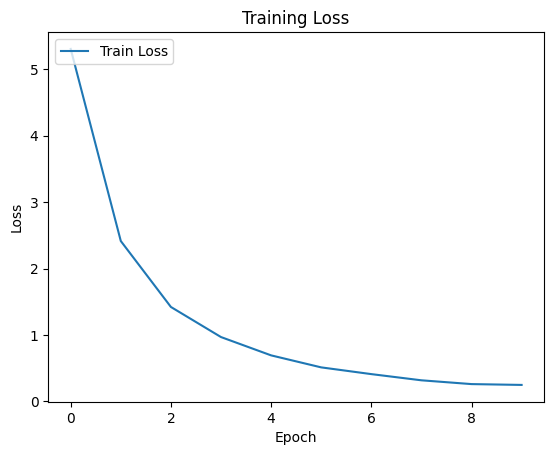

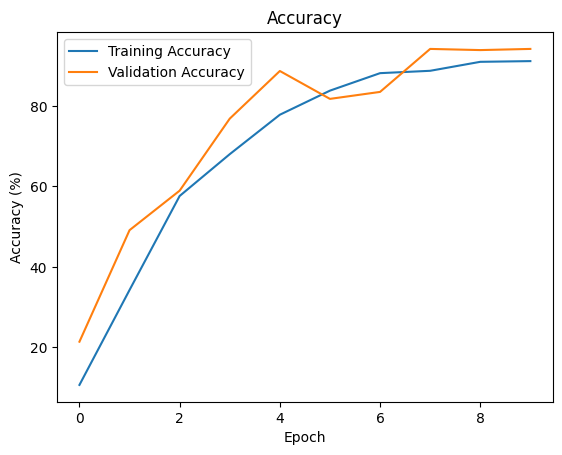

In [43]:
fig_dir = './fig/'
if not os.path.isdir(fig_dir):
    os.makedirs(fig_dir)

# 繪製訓練損失圖表
plt.figure()
plt.plot(list(range(epochs)), loss_epoch_C)  # 繪製訓練損失曲線
plt.title('Training Loss')
plt.ylabel('Loss'), plt.xlabel('Epoch')
plt.legend(['Train Loss'], loc='upper left')
plt.savefig(os.path.join(fig_dir, 'training_loss.png'))
plt.show()

# 繪製訓練和驗證準確率圖表
plt.figure()
plt.plot(list(range(epochs)), train_acc, label='Training Accuracy')  # 繪製訓練準確率曲線
plt.plot(list(range(epochs)), val_acc, label='Validation Accuracy')  # 繪製驗證準確率曲線
plt.title('Accuracy')
plt.ylabel('Accuracy (%)'), plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.savefig(os.path.join(fig_dir, 'accuracy.png'))
plt.show()